In [1]:
# init.py
import numpy as np
import pandas as pd
import zipfile
import dask.dataframe as dk
import dask
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import mixed_precision
import gc
import tenseal as ts 
import os
from monitor import ResourceMonitor

# Bật mixed precision
mixed_precision.set_global_policy('mixed_float16')
tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_jit(True)  # Bật XLA để tối ưu hóa
dask.config.set({"distributed.diagnostics.nvml": False})
# Cấu hình Dask Client với giới hạn tài nguyên (12GB RAM)
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='4GB')
print(client)

# <<< Khởi tạo Homomorphic Encryption Context >>>
print("Đang tạo HE context...")
he_context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=16384,  # <-- TĂNG LÊN để có sức chứa 8192
    coeff_mod_bit_sizes=[60, 40, 60] # <-- Tối ưu cho độ sâu tính toán nông (1 phép nhân)
)
he_context.generate_galois_keys()
he_context.global_scale = 2**40
print("Đã tạo xong HE context.")
# <<< KẾT THÚC >>>


input_files = [f"file{i+1}" for i in range(3)]
temp_dir = "FL_Data/"
input_files = [temp_dir + output_file for output_file in input_files]
print(input_files)

# Đọc dữ liệu Parquet với Dask, chỉ lấy metadata để giảm tải
df = [dk.read_parquet(file, columns=None) for file in input_files]  # Chỉ đọc metadata
print(df[1].dtypes)

batch_size = 512  # Tăng batch_size để giảm số bước
ratio_test_all = 0.2
features_len = len(df[0].columns) - 1  # Giả định tất cả file có cùng cấu trúc
print("Feature Len:", features_len)

# Ước lượng số lượng mẫu từ metadata thay vì tính chính xác
train_sizes = [df_i.shape[0].compute() * (1 - ratio_test_all) for df_i in df]
val_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.25 for df_i in df]
test_sizes = [df_i.shape[0].compute() * ratio_test_all * 0.75 for df_i in df]

train_dfs = []
val_dfs = []
test_dfs = []
for dff in df:
    train_df, val_test_df = dff.random_split([1 - ratio_test_all, ratio_test_all], shuffle=True)
    test_df, val_df = val_test_df.random_split([0.75, 0.25], shuffle=True)
    train_dfs.append(train_df)
    val_dfs.append(val_df)
    test_dfs.append(test_df)

def dask_to_tf_dataset(dask_df, batch_size, features_len):
    def generator():
        for batch in dask_df.to_delayed():
            batch = batch.compute()
            if batch.empty:
                continue
            X = batch.drop(columns=['label']).values.astype(np.float32)
            y = batch['label'].values.astype(np.int32)
            num_splits = max(1, len(X) // batch_size)
            X_batches = np.array_split(X, num_splits)
            y_batches = np.array_split(y, num_splits)
            for X_batch, y_batch in zip(X_batches, y_batches):
                yield X_batch, y_batch
    output_signature = (
        tf.TensorSpec(shape=(None, features_len), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32),
    )
    dataset = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    return dataset.cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000)

train_gens = [dask_to_tf_dataset(train_df, batch_size, features_len).repeat() for train_df in train_dfs]
val_gens = [dask_to_tf_dataset(val_df, batch_size, features_len).repeat() for val_df in val_dfs]
test_gens = [dask_to_tf_dataset(test_df, batch_size, features_len).repeat() for test_df in test_dfs]

from server_new import Server
from client_new import Client
import datetime

num_servers = 1
num_clients = 3

# Ước lượng steps
stepsPerEpoch_Clients = [int(np.ceil(size / batch_size)) for size in train_sizes]
stepsValidate_Clients = [int(np.ceil(size / batch_size)) for size in val_sizes]
stepsTest_Clients = [int(np.ceil(size / batch_size)) for size in test_sizes]

active_servers_list = ['server_' + str(i) for i in range(num_servers)]
active_clients_list = ['client_' + str(i) for i in range(num_clients)]
print(active_servers_list)
print(active_clients_list)

agents_dict = {}
serverObjects = {server_name: Server(server_name=server_name, active_clients_list=active_clients_list)
                 for server_name in active_servers_list}

# <<< CHỈNH SỬA: Thêm he_context khi khởi tạo Client >>>
clientObjects = {client_name: Client(client_name, train_gens[clientID], val_gens[clientID], test_gens[clientID],
                                     stepsPerEpoch_Clients[clientID], stepsValidate_Clients[clientID], stepsTest_Clients[clientID],
                                     active_clients_list=active_clients_list,
                                     he_context=he_context) # TRUYỀN HE CONTEXT VÀO
                 for clientID, client_name in enumerate(active_clients_list)}
# <<< KẾT THÚC CHỈNH SỬA >>>


temp_dir_log = clientObjects['client_0'].get_temp_dir()
for index, client_name in enumerate(active_clients_list):
    clientObjects[client_name].get_steps_per_epoch()
    clientObjects[client_name].get_validation_steps()
    clientObjects[client_name].get_test_steps()

agents_dict['server'] = serverObjects
agents_dict['client'] = clientObjects

for agent_name, agent in serverObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)
for agent_name, agent in clientObjects.items():
    agent.set_agentsDict(agents_dict=agents_dict)

# Giải phóng tài nguyên không cần thiết
del train_dfs, val_dfs, test_dfs, df
gc.collect()

server = agents_dict['server']['server_0']
if __name__ == '__main__':
    monitor = ResourceMonitor(interval=1, gpu_id=0)
    monitor.start()
    try:
        server.InitLoop()
        server.final_statistics()
    finally:
        # 3. Dừng monitor và lưu kết quả, bất kể có lỗi hay không
        resource_df = monitor.stop()
        resource_usage = os.path.join(temp_dir_log, "resource_usage.csv")
        resource_df.to_csv(resource_usage, index=False)
        print(f"Đã lưu kết quả giám sát tài nguyên vào file: {resource_usage}")
        client.close()  # Đóng Dask Client sau khi hoàn tất

2025-07-07 14:57:28.883930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 14:57:28.922213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751875048.951482  184881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751875048.959347  184881 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751875048.987041  184881 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<Client: 'tcp://127.0.0.1:41039' processes=2 threads=4, memory=7.45 GiB>
Đang tạo HE context...
Đã tạo xong HE context.
['FL_Data/file1', 'FL_Data/file2', 'FL_Data/file3']
flow_duration      float64
Header_Length      float64
Protocol Type      float64
Duration           float64
Rate               float64
Srate              float64
Drate              float64
fin_flag_number    float64
syn_flag_number    float64
rst_flag_number    float64
psh_flag_number    float64
ack_flag_number    float64
ece_flag_number    float64
cwr_flag_number    float64
ack_count          float64
syn_count          float64
fin_count          float64
urg_count          float64
rst_count          float64
HTTP               float64
HTTPS              float64
DNS                float64
Telnet             float64
SMTP               float64
SSH                float64
IRC                float64
TCP                float64
UDP                float64
DHCP               float64
ARP                float64
ICMP              

I0000 00:00:1751875055.870780  184881 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


['server_0']
['client_0', 'client_1', 'client_2']
Train steps: 5338
Val steps: 334
Test steps: 1001
Train steps: 3739
Val steps: 234
Test steps: 702
Train steps: 4262
Val steps: 267
Test steps: 800
Giám sát GPU 0 đã được kích hoạt.
>> Bắt đầu giám sát tài nguyên...
====================================== Đang chạy Iteration 1 ======================================
Epoch 1/10
Epoch 1/10
Epoch 1/10


I0000 00:00:1751875058.811656  185002 service.cc:152] XLA service 0x7f79fc006390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751875058.811735  185002 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
I0000 00:00:1751875058.830568  185002 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751875058.987851  185004 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-07-07 14:57:42.300244: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-07 14:57:43.650496: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_969', 116 bytes spill stores, 116 bytes spill loads

2025-07-07 14:57:43.66338

   1/5338 ━━━━━━━━━━━━━━━━━━━━ 13:29:43 9s/step - accuracy: 0.1793 - loss: 2.1174

2025-07-07 14:57:46.475909: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-07-07 14:57:46.478427: W external/local_xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1369] AutotunerUtil::AddResult already existed: <key model='CUDA: 8.9, Cores: 20, GPU clock: 2.055 GHz, Memory bandwidth: 192 GB/s, L2 cache: 24 MB', hlo='{
  tmp_0 = f16[513,128]{1,0} parameter(0)
  tmp_1 = f16[736,128]{1,0} parameter(1)
  tmp_2 = f16[513,736]{1,0} dot(f16[513,128]{1,0} tmp_0, f16[736,128]{1,0} tmp_1), lhs_contracting_dims={1}, rhs_contracting_dims={1}, frontend_attributes={grad_x="true",grad_y="false"}
  ROOT tmp_3 = f16[377568,1,1,1,1]{4,3,2,1,0} bitcast(f16[513,736]{1,0} tmp_2)
}'>


4811/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9043 - loss: 0.2798

2025-07-07 14:58:16.438178: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 14:58:16.545678: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 16 bytes spill stores, 16 bytes spill loads



4847/5338 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9046 - loss: 0.2790

2025-07-07 14:58:16.640817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 688 bytes spill stores, 608 bytes spill loads



5075/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9061 - loss: 0.2740

2025-07-07 14:58:18.084922: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 304 bytes spill stores, 304 bytes spill loads



5104/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9063 - loss: 0.2734

2025-07-07 14:58:18.307751: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 688 bytes spill stores, 608 bytes spill loads



5157/5338 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9066 - loss: 0.2723

2025-07-07 14:58:18.628852: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 16 bytes spill stores, 16 bytes spill loads



5324/5338 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9077 - loss: 0.2689

2025-07-07 14:58:20.285003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 14:58:20.287109: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 14:58:20.378338: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 688 bytes spill stores, 608 bytes spill loads

2025-07-07 14:58:20.399309: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 16 bytes spill stores, 16 bytes spill loads

2025-07-07 14:58:20.700986: I external/loc

3739/3739 ━━━━━━━━━━━━━━━━━━━━ 100s 24ms/step - accuracy: 0.8968 - loss: 0.3071 - val_accuracy: 0.9529 - val_loss: 0.1226
Epoch 2/10
 123/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9496 - loss: 0.1280

2025-07-07 14:59:17.893287: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 14:59:18.029216: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 16 bytes spill stores, 16 bytes spill loads



 162/3739 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9499 - loss: 0.1274

2025-07-07 14:59:18.144349: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_65', 688 bytes spill stores, 608 bytes spill loads



 712/3739 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9509 - loss: 0.1249

2025-07-07 14:59:20.172217: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 14:59:20.180955: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 16 bytes spill stores, 16 bytes spill loads

2025-07-07 14:59:20.329177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 688 bytes spill stores, 608 bytes spill loads



5338/5338 ━━━━━━━━━━━━━━━━━━━━ 106s 18ms/step - accuracy: 0.9078 - loss: 0.2686 - val_accuracy: 0.9536 - val_loss: 0.1136
Epoch 2/10
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 108s 23ms/step - accuracy: 0.9043 - loss: 0.2893 - val_accuracy: 0.9530 - val_loss: 0.1168
Epoch 2/10
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9514 - loss: 0.1229 - val_accuracy: 0.9547 - val_loss: 0.1142
Epoch 3/10
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9525 - loss: 0.1189 - val_accuracy: 0.9550 - val_loss: 0.1111
Epoch 3/10
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9524 - loss: 0.1190 - val_accuracy: 0.9557 - val_loss: 0.1137
Epoch 3/10
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9535 - loss: 0.1159 - val_accuracy: 0.9561 - val_loss: 0.1078
Epoch 4/10
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9547 - loss: 0.1125 - val_accuracy: 0.9571 - val_loss: 0.1070
Epoch 4/10
3739/3739 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9546 - loss: 0.1130 -

/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1854/4262 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9584 - loss: 0.1029[client_1] Bắt đầu mã hóa tham số theo chunks...
1855/4262 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9584 - loss: 0.1029[client_1] Mã hóa 12 weight chunks và 1 bias chunks hoàn tất.
client_1 End Produce Weights
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9566 - loss: 0.1068 - val_accuracy: 0.9588 - val_loss: 0.1009
Epoch 8/10
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9583 - loss: 0.1034 - val_accuracy: 0.9589 - val_loss: 0.1015
Epoch 10/10
5338/5338 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9570 - loss: 0.1060 - val_accuracy: 0.9586 - val_loss: 0.1004
Epoch 9/10
4262/4262 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9582 - loss: 0.1034 - val_accuracy: 0.9578 - val_loss: 0.1032
1481/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9576 - loss: 0.1050Done model fit

1490/5338 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9576 - loss: 0.1050[client_2] Bắt đầu mã 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



5338/5338 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9613 - loss: 0.0947 - val_accuracy: 0.9629 - val_loss: 0.0897
Done model fit

[client_0] Bắt đầu mã hóa tham số theo chunks...
[client_0] Mã hóa 12 weight chunks và 1 bias chunks hoàn tất.
client_0 End Produce Weights
[client_0] Nhận global model, bắt đầu giải mã các chunks...
[client_1] Nhận global model, bắt đầu giải mã các chunks...
[client_0] Giải mã và tái tạo từ chunks hoàn tất.
[client_2] Nhận global model, bắt đầu giải mã các chunks...
[client_1] Giải mã và tái tạo từ chunks hoàn tất.
[client_2] Giải mã và tái tạo từ chunks hoàn tất.
Đã lưu global model cho iteration 9 tại multiclass_FL_log/Month07-Day07-14h-57p/client_2_log/global_model_iter_9.keras
Đã lưu global model cho iteration 9 tại multiclass_FL_log/Month07-Day07-14h-57p/client_1_log/global_model_iter_9.keras
Đã lưu global model cho iteration 9 tại multiclass_FL_log/Month07-Day07-14h-57p/client_0_log/global_model_iter_9.keras
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/s

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9629 - loss: 0.0895
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9627 - loss: 0.0900
1001/1001 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9629 - loss: 0.0893
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9634 - loss: 0.0885
Arguments:  Performance Metrics for client_2 on iteration 10 
------------------------------------------- 
local accuracy: 0.9631373286247253 
local loss: 0.08986777812242508 
global accuracy: 0.9632512331008911 
global_loss: 0.08874325454235077 
local compute time: 0:03:26.382961 
Simulated time to receive global weights: 0:03:56.310279 
 

702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9625 - loss: 0.0901
Arguments:  Performance Metrics for client_1 on iteration 10 
------------------------------------------- 
local accuracy: 0.9628009796142578 
local loss: 0.08971183747053146 
global accuracy: 0.9626926779747009 
global_loss: 0.08965691179037094 
local compute time: 0:03:03.976

2025-07-07 15:41:35,183 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/distributed/worker.py", line 1250, in heartbeat
    response = await retry_operation(
  File "/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/distributed/utils_comm.py", line 459, in retry_operation
    return await retry(
  File "/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/distributed/utils_comm.py", line 438, in retry
    return await coro()
  File "/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/distributed/core.py", line 1

In [2]:
import os
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Giả định các biến global như tempdirs, active_clients_list, test_gens, stepsTest_Clients đã được định nghĩa
tempdirs = [temp_dir_log + f"/client_{i}_log/" for i in range(len(active_clients_list))]

# Tự động xác định số iteration cho từng client
model_names_template = [f"global_model_iter_{i+1}.keras" for i in range(10)]  # Danh sách tiềm năng
actual_iterations = {}
for i, client_dir in enumerate(tempdirs):
    existing_models = [m for m in model_names_template if os.path.exists(client_dir + m)]
    if existing_models:
        current_max = max([int(m.split('_')[-1].split('.')[0]) for m in existing_models])
        actual_iterations[f'client_{i}'] = current_max
    else:
        actual_iterations[f'client_{i}'] = 10  # Mặc định 8 nếu không tìm thấy tệp
model_names = {f'client_{i}': [f"global_model_iter_{j}.keras" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
Iterations = {f'client_{i}': [f"Iteration {j}" for j in range(1, actual_iterations[f'client_{i}'] + 1)] for i in range(len(active_clients_list))}
print(f"Detected iterations: {actual_iterations}")

# Load models
models = {}
for i, client_name in enumerate(active_clients_list):
    models[client_name] = [load_model(tempdirs[i] + model_name) for model_name in model_names[client_name]]
print(models['client_0'])

Detected iterations: {'client_0': 10, 'client_1': 10, 'client_2': 10}


/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 22 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/th/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[<Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>, <Sequential name=sequential, built=True>]


2025-07-07 15:41:37.657023: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


517602
<Sequential name=sequential, built=True>


2025-07-07 15:41:38.319554: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-07-07 15:41:38.725021: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 268 bytes spill stores, 268 bytes spill loads

2025-07-07 15:41:38.809101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 8 bytes spill stores, 8 bytes spill loads

2025-07-07 15:41:38.921728: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 12 bytes spill stores, 12 bytes spill loads

2025-07-07 15:41:39.082194: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc

16149/16176 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step

2025-07-07 15:41:56.044244: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 304 bytes spill stores, 304 bytes spill loads

2025-07-07 15:41:56.194511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 24 bytes spill stores, 24 bytes spill loads



16176/16176 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
<Sequential name=sequential, built=True>
16176/16176 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step
Precision Score:  [0.668402080940289, 0.910106721899453, 0.9070813175815738, 0.9038339288430095, 0.9047800498115193, 0.9037533630477841, 0.9087277804434045, 0.907887491235

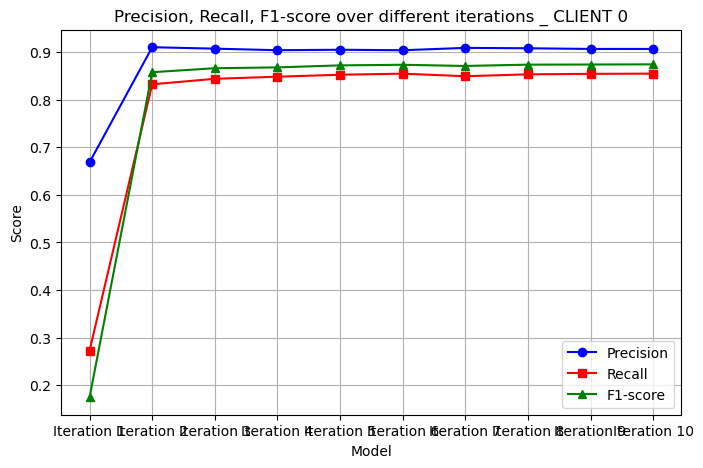

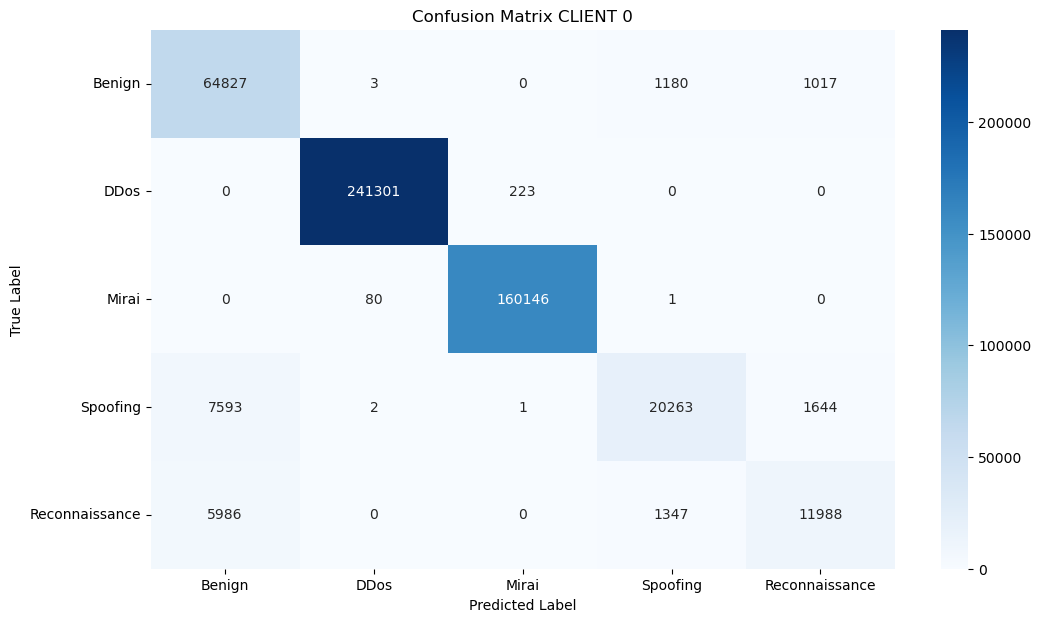

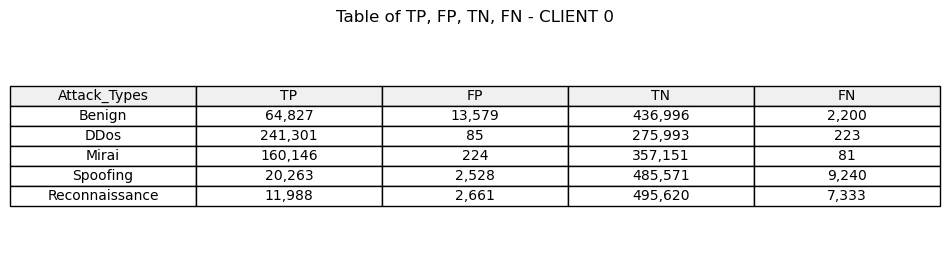

/tmp/ipykernel_184881/3875102694.py:99: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


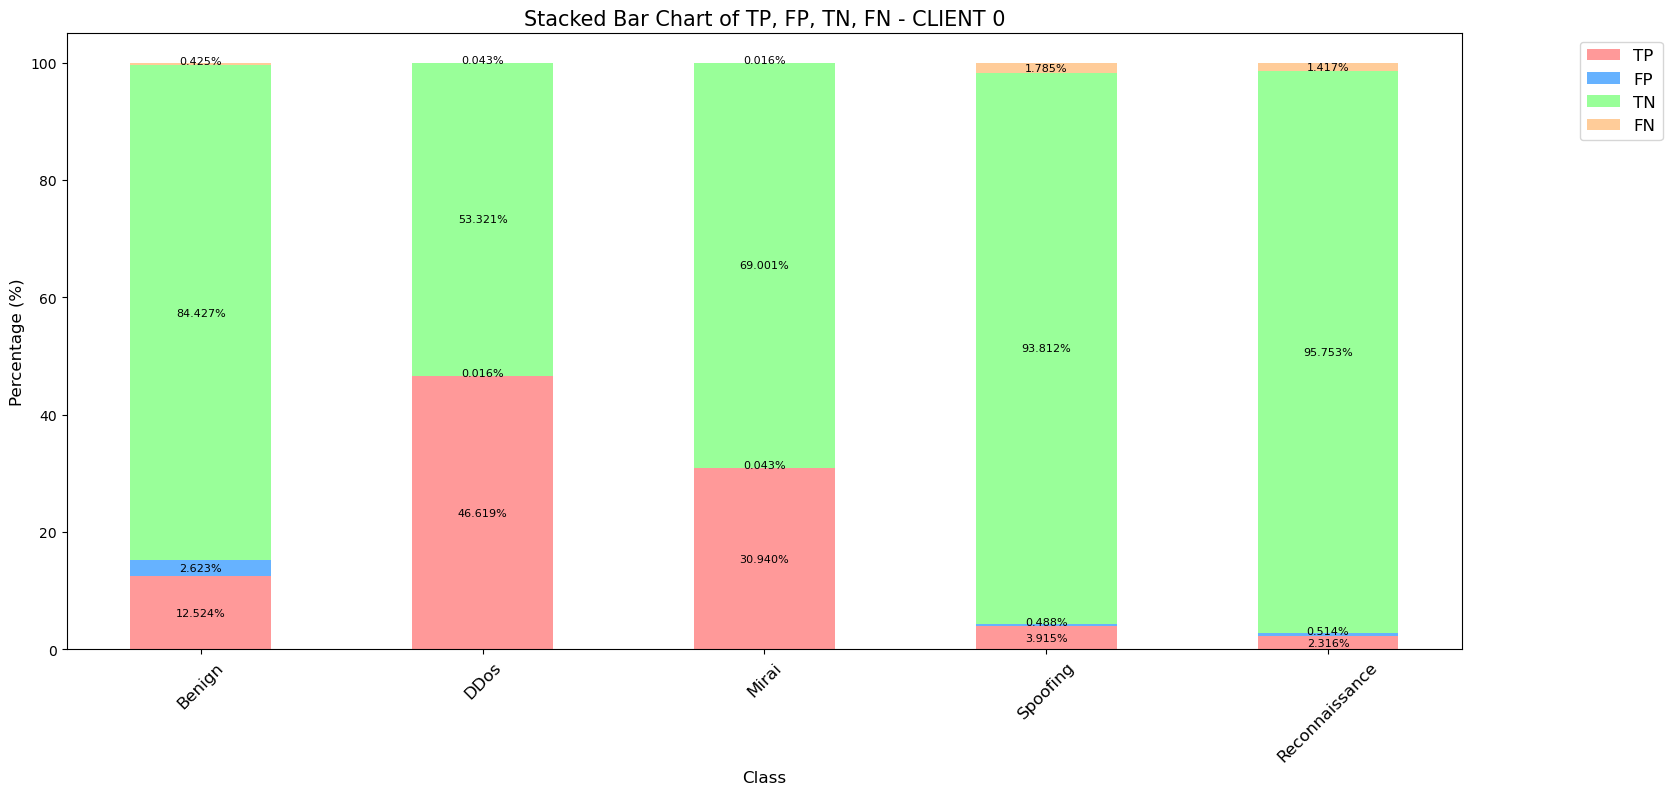

In [3]:
# Client 0
precisions = []
recalls = []
f1s = []

X_test = []
y_test = []
for X_batch, y_batch in test_gens[0].take(stepsTest_Clients[0]):
    X_test.append(X_batch.numpy())
    y_test.append(y_batch.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(len(X_test))
for iteration in range(actual_iterations['client_0']):
    print(models['client_0'][iteration])
    y_pred_pre = models['client_0'][iteration].predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_pre, axis=1)
    
    precisions.append(precision_score(y_test, y_pred, average='macro'))
    recalls.append(recall_score(y_test, y_pred, average='macro'))
    f1s.append(f1_score(y_test, y_pred, average='macro'))
print("Precision Score: ", precisions)
print("Recall Score: ", recalls)
print("F1 Score: ", f1s)

# Vẽ biểu đồ Precision, Recall, F1-score
plt.figure(figsize=(8, 5))
plt.plot(Iterations['client_0'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
plt.plot(Iterations['client_0'], recalls, marker='s', linestyle='-', label="Recall", color='red')
plt.plot(Iterations['client_0'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score over different iterations _ CLIENT 0")
plt.legend()
plt.grid(True)
plt.savefig(tempdirs[0] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
plt.show()

attack_types = ['Benign', 'DDos', 'Mirai', 'Spoofing', 'Reconnaissance']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
plt.yticks(rotation=360)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix CLIENT 0")
plt.savefig(tempdirs[0] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# Tính và vẽ TP, FP, TN, FN
metrics = []
num_classes = len(attack_types)
for i in range(num_classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    metrics.append([attack_types[i], TP, FP, TN, FN])

df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                 colColours=["#f0f0f0"] * len(df_metrics.columns))
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
ax.set_title("Table of TP, FP, TN, FN - CLIENT 0")
#plt.tight_layout(pad=0.5)
plt.savefig(tempdirs[0] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
    df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
) * 100

fig, ax = plt.subplots(figsize=(18, 8))
bottom = np.zeros(len(df_metrics))
colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
    bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height > 0:
            y_pos = bottom[i] + height / 2
            if height < 1:
                y_pos += 0.5
            ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                    f'{height:.3f}%', ha="center", va="center", rotation=0,
                    fontsize=8, color="black")
    bottom += df_metrics[metric]

ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_title("Stacked Bar Chart of TP, FP, TN, FN - CLIENT 0", fontsize=15)
ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
#plt.tight_layout(pad=1.0)
plt.savefig(tempdirs[0] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
plt.show()

2025-07-07 15:45:00.261886: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


363125
<Sequential name=sequential_1, built=True>
11339/11348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-07-07 15:45:13.132263: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 16 bytes spill stores, 16 bytes spill loads

2025-07-07 15:45:13.213420: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 12 bytes spill stores, 12 bytes spill loads

2025-07-07 15:45:13.374228: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 196 bytes spill stores, 196 bytes spill loads

2025-07-07 15:45:13.434940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_46', 304 bytes spill stores, 304 bytes spill loads



11348/11348 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
<Sequential name=sequential_1, built=True>
11348/11348 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Precision Score Client 1:  [0.6039372489559749, 0.897466961108148, 0.8991890358828438, 0.9022993812110341, 0.9050777236707095, 0.904828681937197, 0.90342

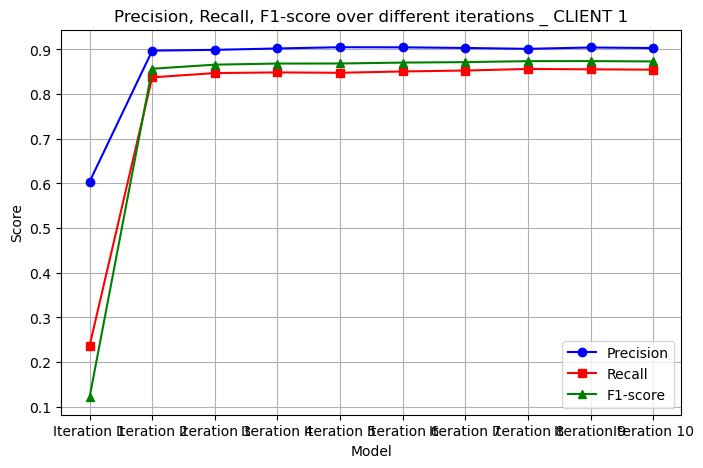

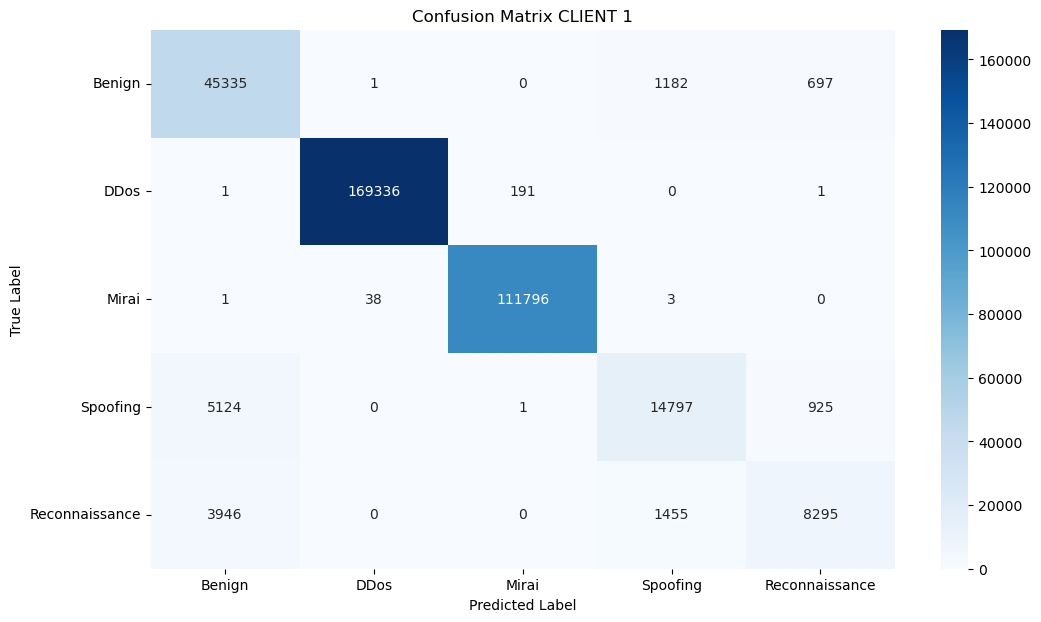

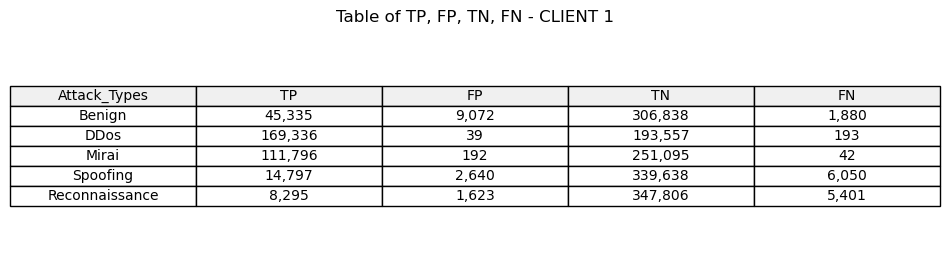

/tmp/ipykernel_184881/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


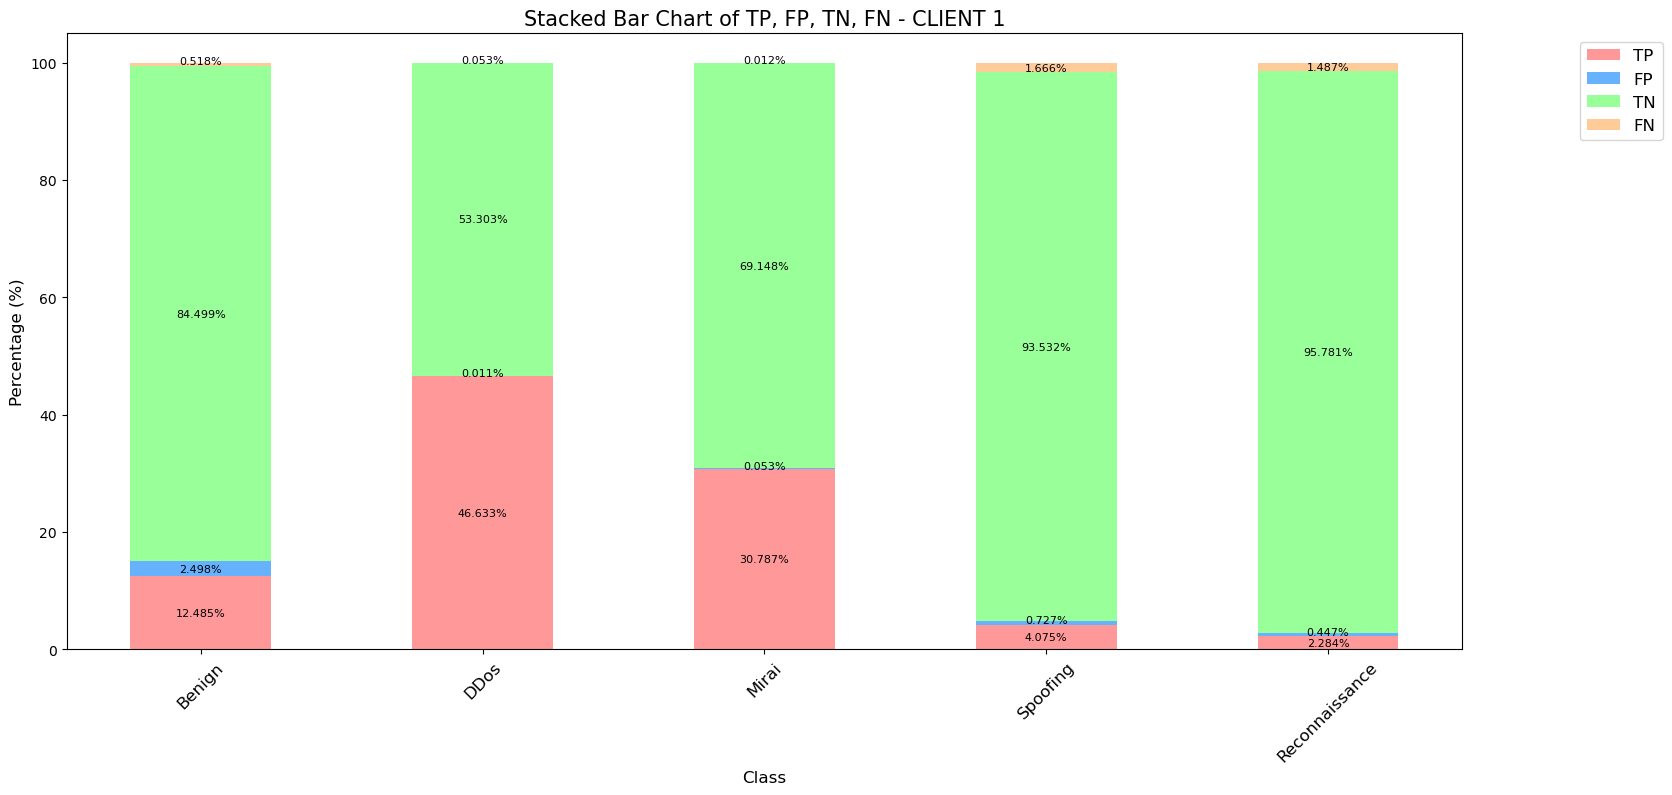

413602
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step
<Sequential name=sequential_2, built=True>
12926/12926 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step
Precision Score Client 2:  [0.6548002867644287, 0.8984518595310922, 0.8906029774156593, 0.8969369332497

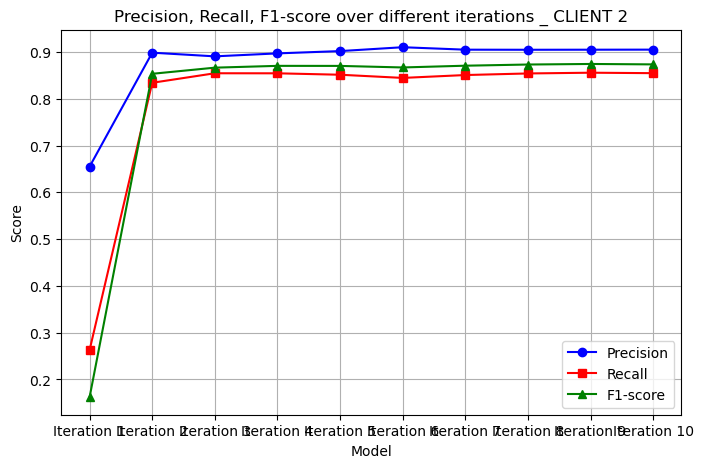

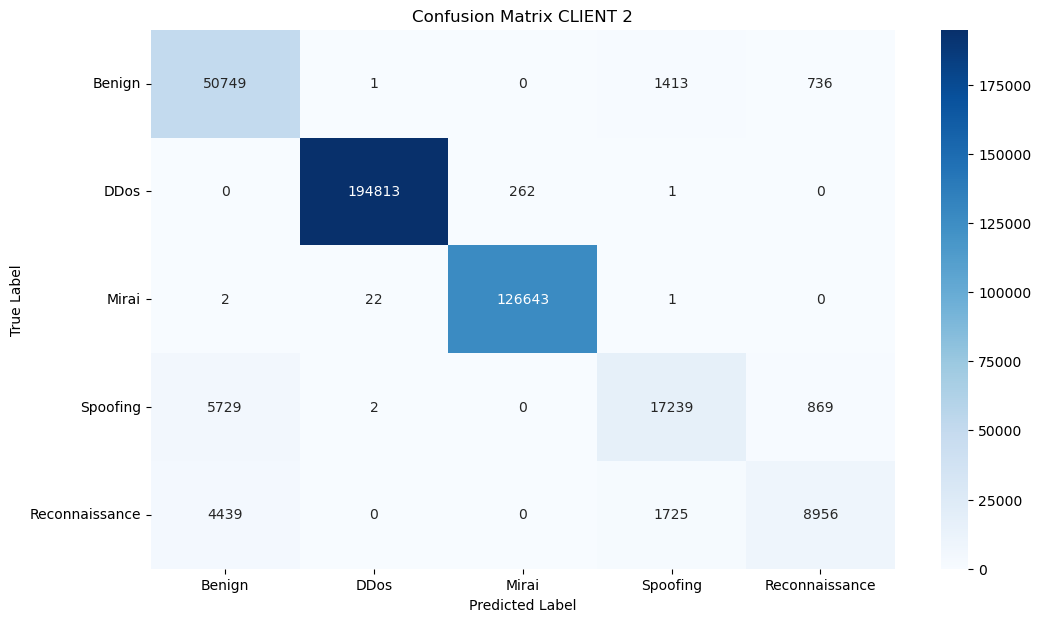

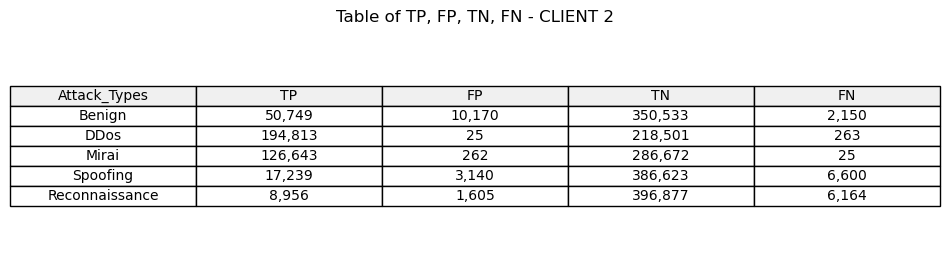

/tmp/ipykernel_184881/3207210425.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)


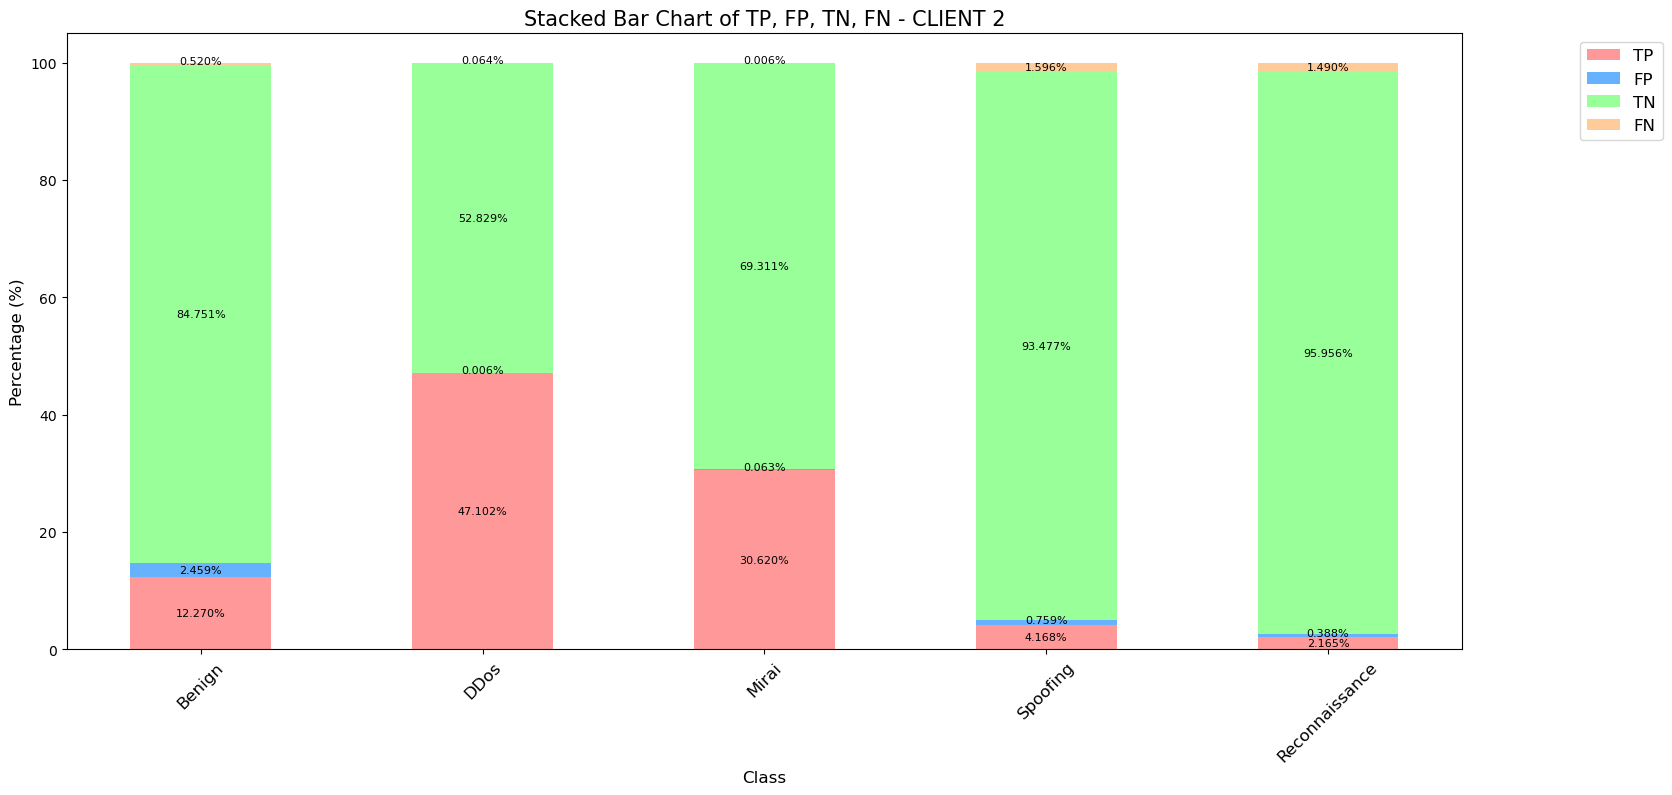

In [4]:
# Lặp cho Client 1 và Client 2
for client_idx in [1, 2]:
    precisions = []
    recalls = []
    f1s = []

    X_test = []
    y_test = []
    for X_batch, y_batch in test_gens[client_idx].take(stepsTest_Clients[client_idx]):
        X_test.append(X_batch.numpy())
        y_test.append(y_batch.numpy())
    X_test = np.concatenate(X_test, axis=0)
    y_test = np.concatenate(y_test, axis=0)

    print(len(X_test))
    for iteration in range(actual_iterations[f'client_{client_idx}']):
        print(models[f'client_{client_idx}'][iteration])
        y_pred_pre = models[f'client_{client_idx}'][iteration].predict(X_test, verbose=1)
        y_pred = np.argmax(y_pred_pre, axis=1)
        
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred, average='macro'))
        f1s.append(f1_score(y_test, y_pred, average='macro'))
    print(f"Precision Score Client {client_idx}: ", precisions)
    print(f"Recall Score Client {client_idx}: ", recalls)
    print(f"F1 Score Client {client_idx}: ", f1s)

    # Vẽ biểu đồ Precision, Recall, F1-score
    plt.figure(figsize=(8, 5))
    plt.plot(Iterations[f'client_{client_idx}'], precisions, marker='o', linestyle='-', label="Precision", color='blue')
    plt.plot(Iterations[f'client_{client_idx}'], recalls, marker='s', linestyle='-', label="Recall", color='red')
    plt.plot(Iterations[f'client_{client_idx}'], f1s, marker='^', linestyle='-', label="F1-score", color='green')
    plt.xlabel("Model")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall, F1-score over different iterations _ CLIENT {client_idx}")
    plt.legend()
    plt.grid(True)
    plt.savefig(tempdirs[client_idx] + "/pre_recall_f1.png", dpi=300, bbox_inches="tight")
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=attack_types, yticklabels=attack_types)
    plt.yticks(rotation=360)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix CLIENT {client_idx}")
    plt.savefig(tempdirs[client_idx] + "/confusion_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()

    metrics = []
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        metrics.append([attack_types[i], TP, FP, TN, FN])

    df_metrics = pd.DataFrame(metrics, columns=["Attack_Types", "TP", "FP", "TN", "FN"])
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis("off")
    table_data = [[f"{x:,.0f}" if isinstance(x, (int, float)) else x for x in row] for row in df_metrics.values]
    table = ax.table(cellText=table_data, colLabels=df_metrics.columns, loc="center", cellLoc="center",
                     colColours=["#f0f0f0"] * len(df_metrics.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.set_title(f"Table of TP, FP, TN, FN - CLIENT {client_idx}")
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/table_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()

    df_metrics[["TP", "FP", "TN", "FN"]] = df_metrics[["TP", "FP", "TN", "FN"]].div(
        df_metrics[["TP", "FP", "TN", "FN"]].sum(axis=1), axis=0
    ) * 100

    fig, ax = plt.subplots(figsize=(18, 8))
    bottom = np.zeros(len(df_metrics))
    colors = ["#FF9999", "#66B2FF", "#99FF99", "#FFCC99"]

    for metric, color in zip(["TP", "FP", "TN", "FN"], colors):
        bars = ax.bar(df_metrics["Attack_Types"], df_metrics[metric], width=0.5, label=metric, bottom=bottom, color=color)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:
                y_pos = bottom[i] + height / 2
                if height < 1:
                    y_pos += 0.5
                ax.text(bar.get_x() + bar.get_width() / 2, y_pos,
                        f'{height:.3f}%', ha="center", va="center", rotation=0,
                        fontsize=8, color="black")
        bottom += df_metrics[metric]

    ax.set_xlabel("Class", fontsize=12)
    ax.set_ylabel("Percentage (%)", fontsize=12)
    ax.set_title(f"Stacked Bar Chart of TP, FP, TN, FN - CLIENT {client_idx}", fontsize=15)
    ax.set_xticklabels(df_metrics["Attack_Types"], rotation=45, fontsize=12)
    ax.legend(loc="upper right", fontsize=12, bbox_to_anchor=(1.15, 1))
    #plt.tight_layout(pad=1.0)
    plt.savefig(tempdirs[client_idx] + "/stacked_bar_chart_tp_fp_tn_fn.png", dpi=300, bbox_inches="tight")
    plt.show()


Log files: {'client_0': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv', 'Iteration_9.csv', 'Iteration_10.csv'], 'client_1': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv', 'Iteration_9.csv', 'Iteration_10.csv'], 'client_2': ['Iteration_1.csv', 'Iteration_2.csv', 'Iteration_3.csv', 'Iteration_4.csv', 'Iteration_5.csv', 'Iteration_6.csv', 'Iteration_7.csv', 'Iteration_8.csv', 'Iteration_9.csv', 'Iteration_10.csv']}


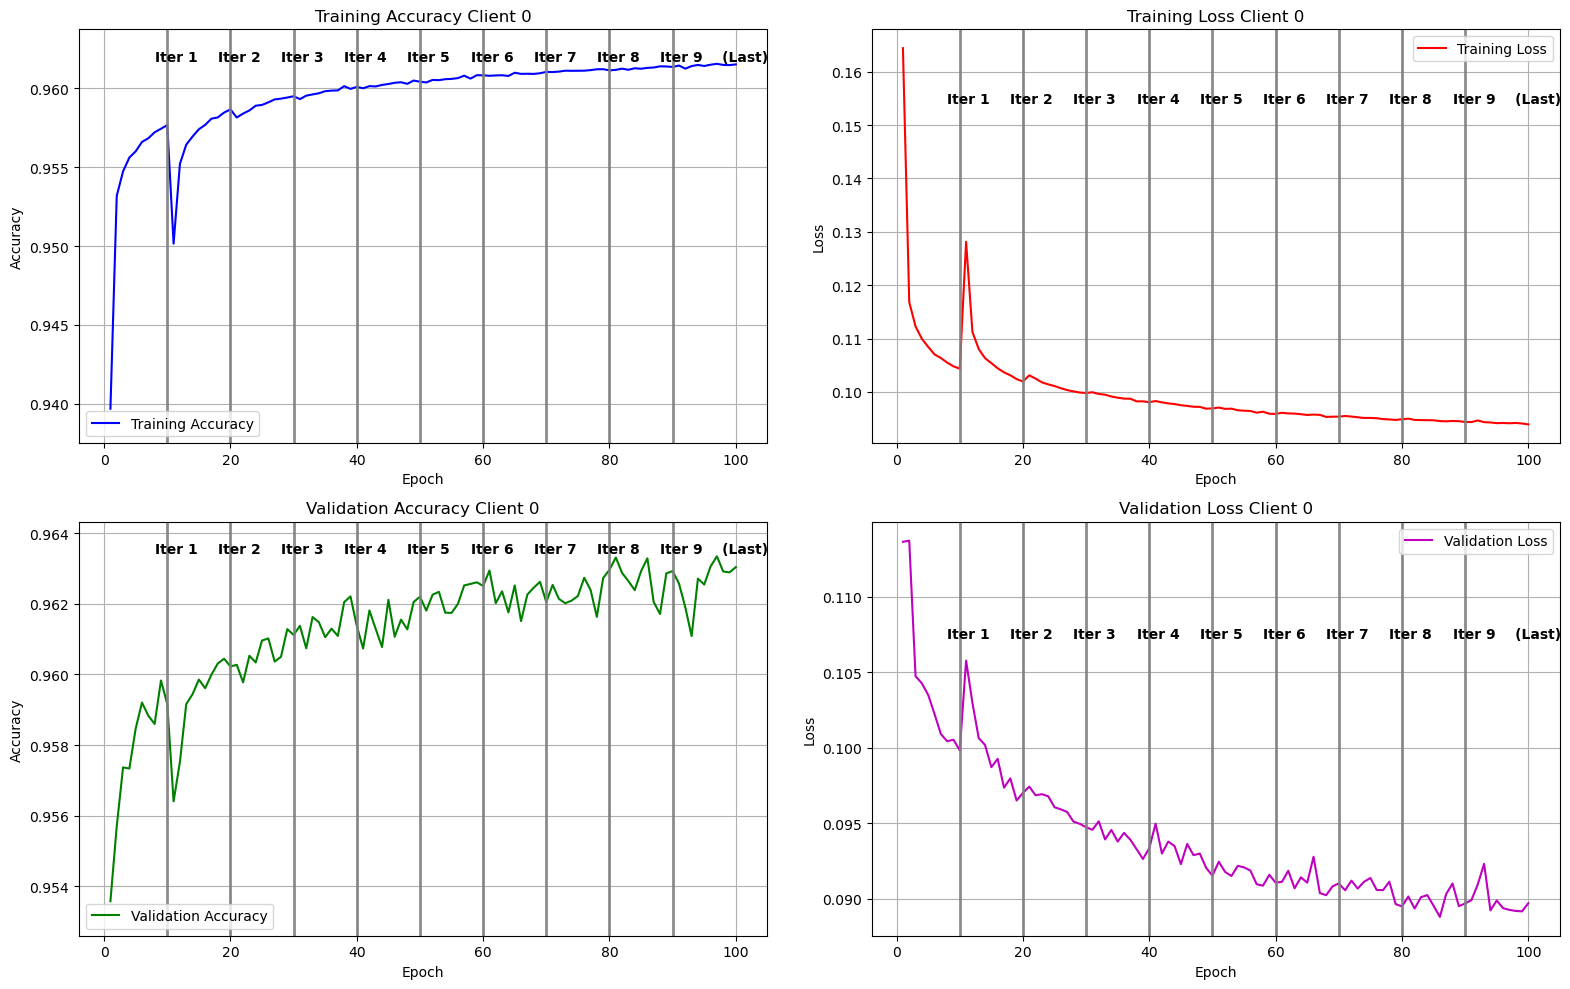

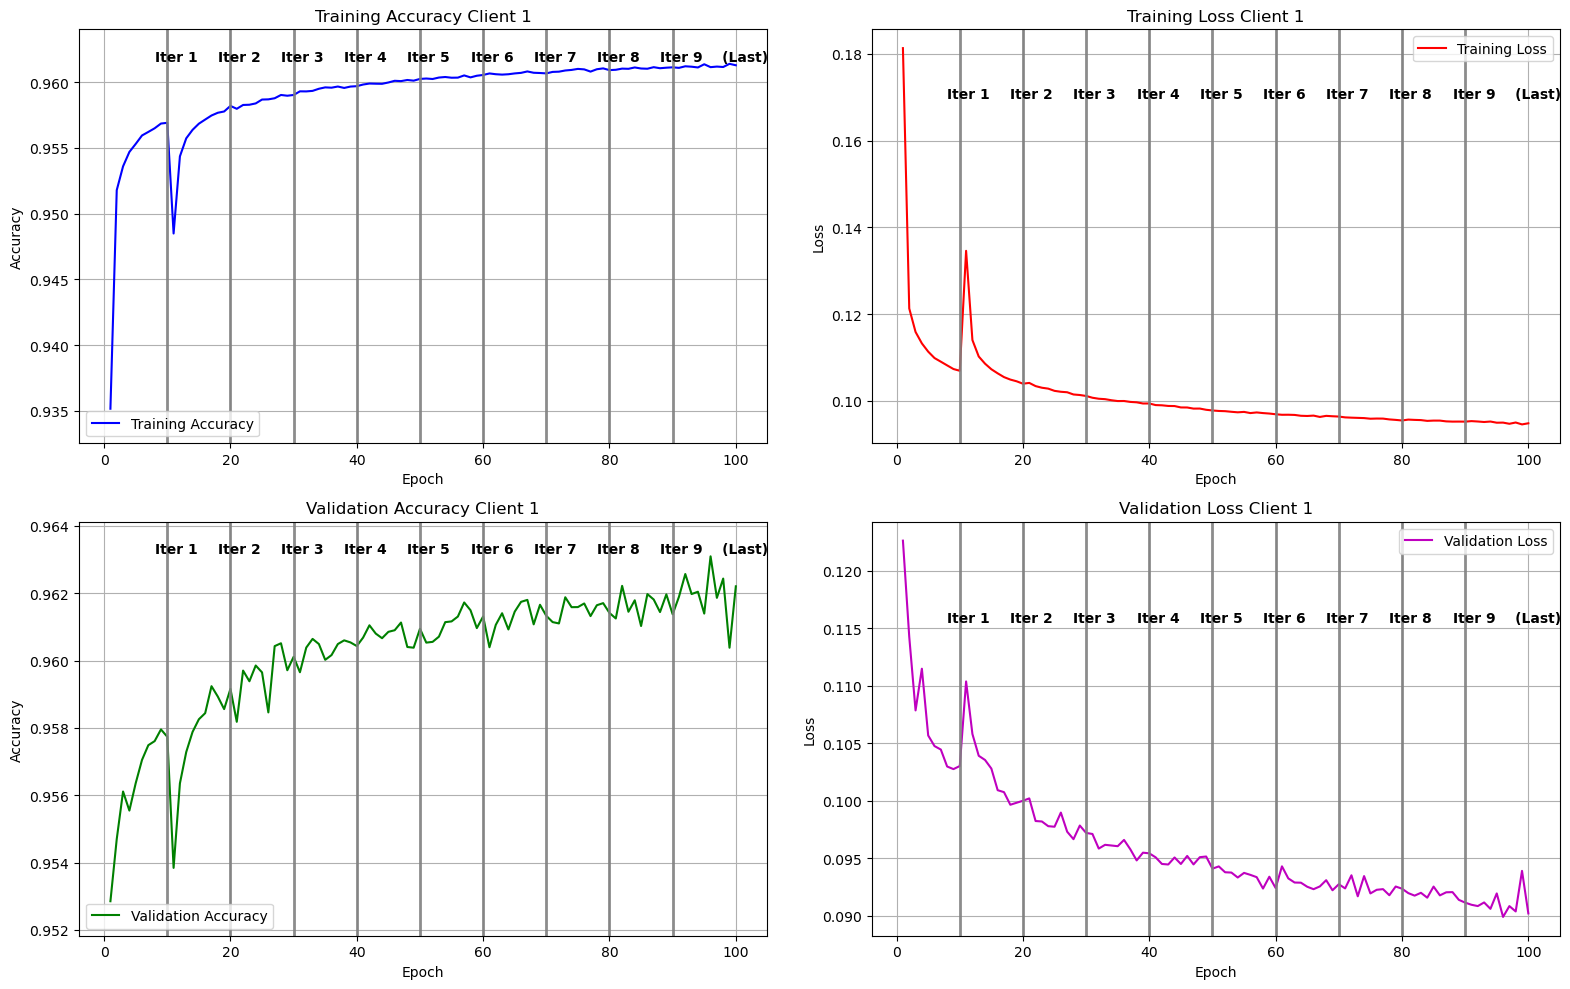

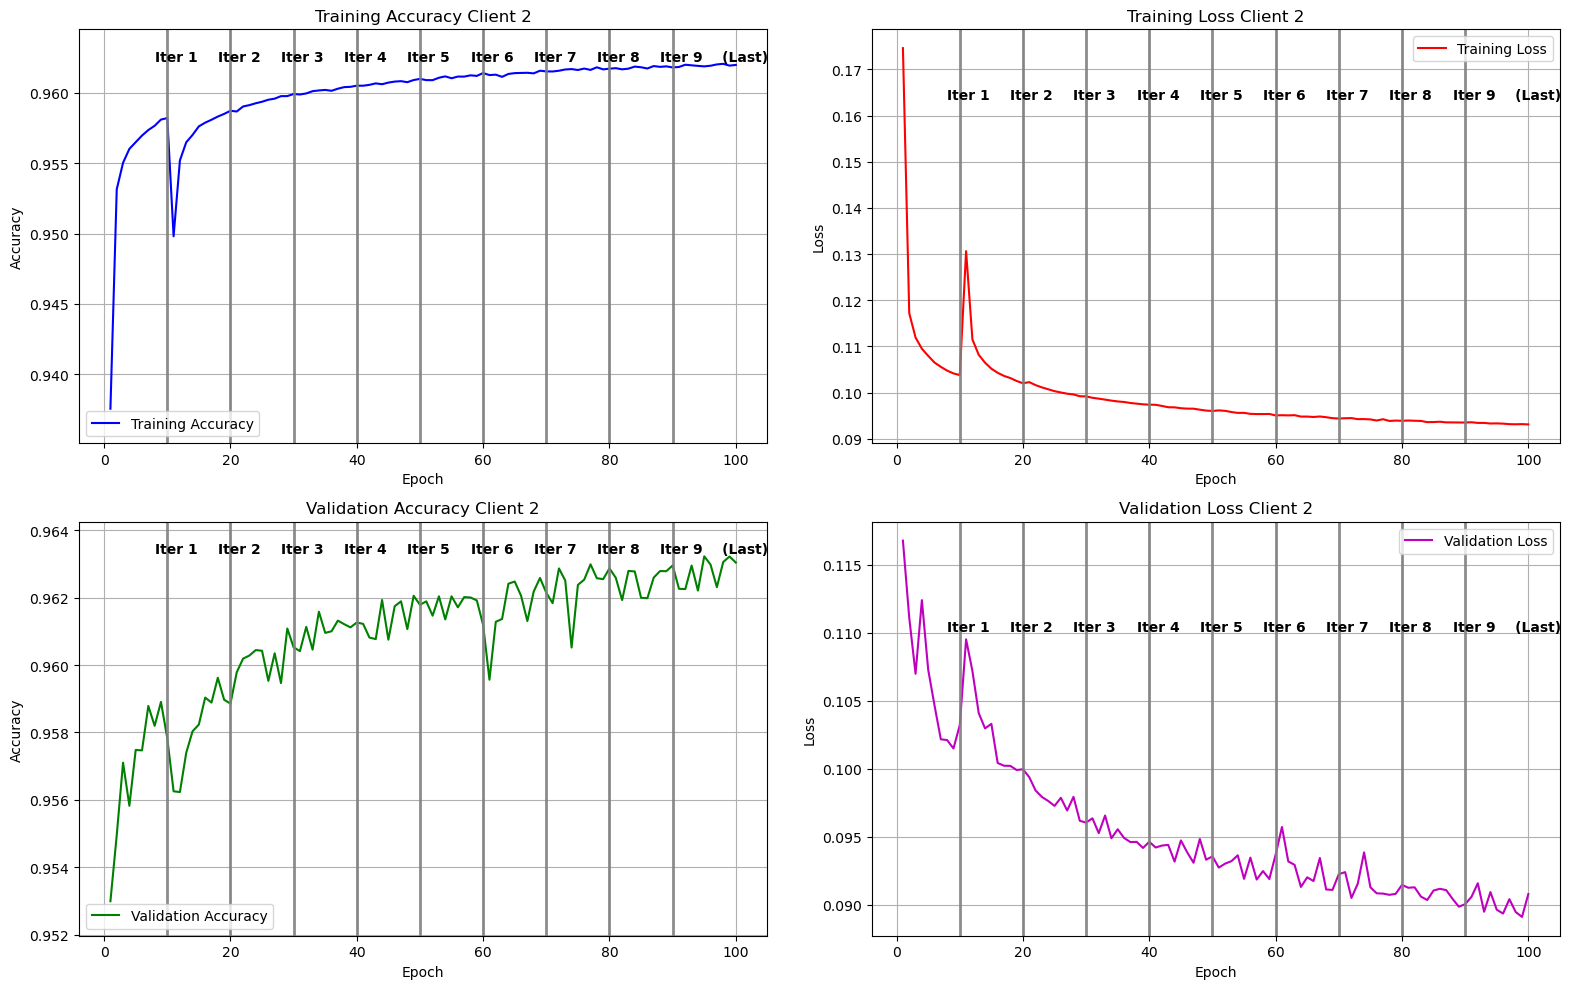

In [5]:
# Phần vẽ biểu đồ log (đã điều chỉnh để tự động tính số epoch)
log_names = {f'client_{i}': [f"Iteration_{j+1}.csv" for j in range(actual_iterations[f'client_{i}'])] for i in range(len(active_clients_list))}
print(f"Log files: {log_names}")

for i in range(len(active_clients_list)):
    all_logs = []
    for log_name in log_names[f'client_{i}']:
        file_path = tempdirs[i] + log_name
        if not os.path.exists(file_path):
            print(f"File {file_path} không tồn tại!")
            continue
        log_part = pd.read_csv(file_path)
        all_logs.append(log_part)

    if not all_logs:
        print(f"No log files found for client_{i}, skipping log plots.")
        continue

    log_df = pd.concat(all_logs, ignore_index=True)
    epochs = range(1, len(log_df) + 1)
    total_epochs = len(log_df)
    epochs_per_iteration = total_epochs // actual_iterations[f'client_{i}']  # Tính số epoch trung bình mỗi iteration

    plt.figure(figsize=(16, 10))

    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, log_df['accuracy'], 'b-', label='Training Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_acc = max(log_df['accuracy']) if not log_df['accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Training Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, log_df['val_accuracy'], 'g-', label='Validation Accuracy')
    plt.margins(y=0.1)  # Thêm khoảng cách 10% trên cùng để chứa nhãn
    max_val_acc = max(log_df['val_accuracy']) if not log_df['val_accuracy'].empty else 1.0
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        y_pos = max_val_acc
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, y_pos, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='bottom', fontsize=10, fontweight='bold')
    plt.title(f'Validation Accuracy Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, log_df['loss'], 'r-', label='Training Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Training Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, log_df['val_loss'], 'm-', label='Validation Loss')
    for iter_idx in range(1, actual_iterations[f'client_{i}']):
        boundary_epoch = iter_idx * epochs_per_iteration  # Vị trí đường gạch dựa trên số epoch thực tế
        plt.axvline(x=boundary_epoch, color='gray', linestyle='-', linewidth=2, alpha=0.9)
        if iter_idx < actual_iterations[f'client_{i}'] - 1:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
        else:
            plt.text(boundary_epoch - 2, max(log_df['val_loss']) * 0.95, f'Iter {iter_idx}    (Last)', rotation=0, verticalalignment='top', fontsize=10, fontweight='bold')
    plt.title(f'Validation Loss Client {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/train_valid_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

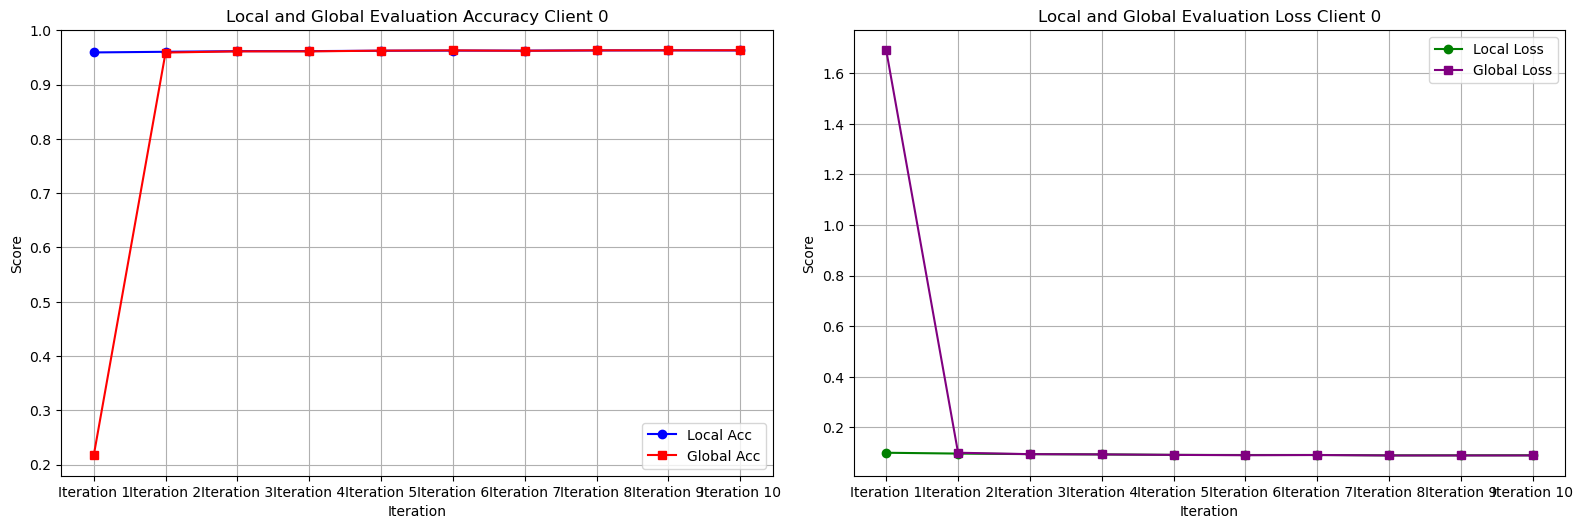

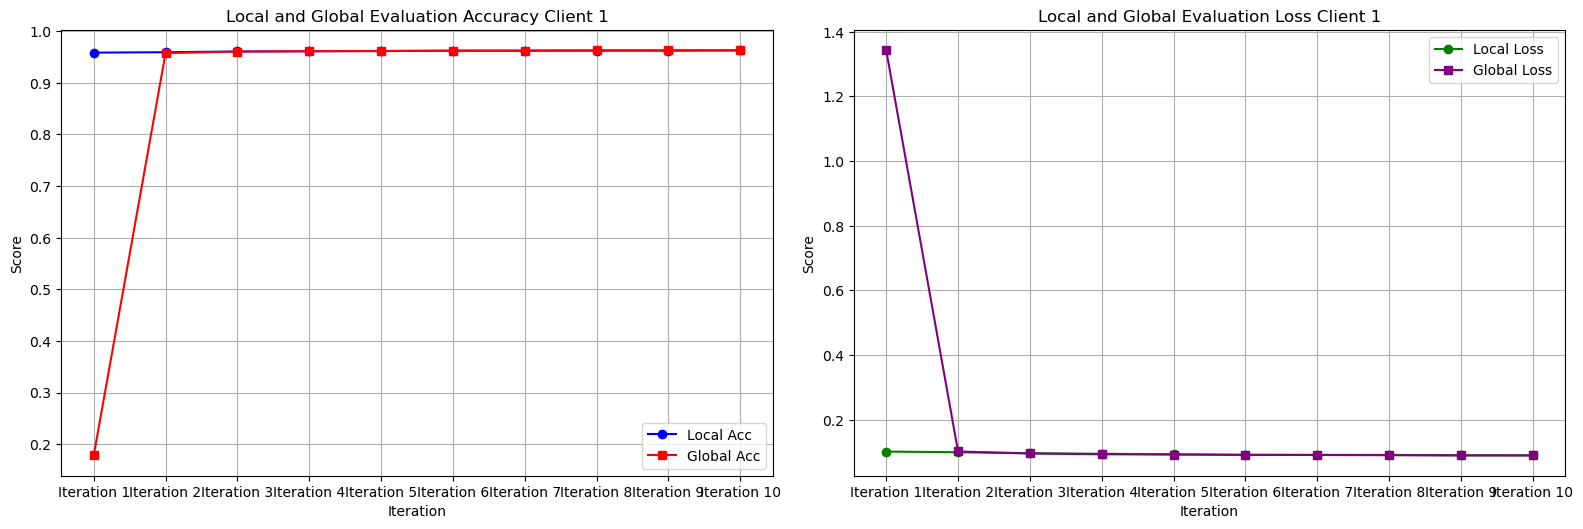

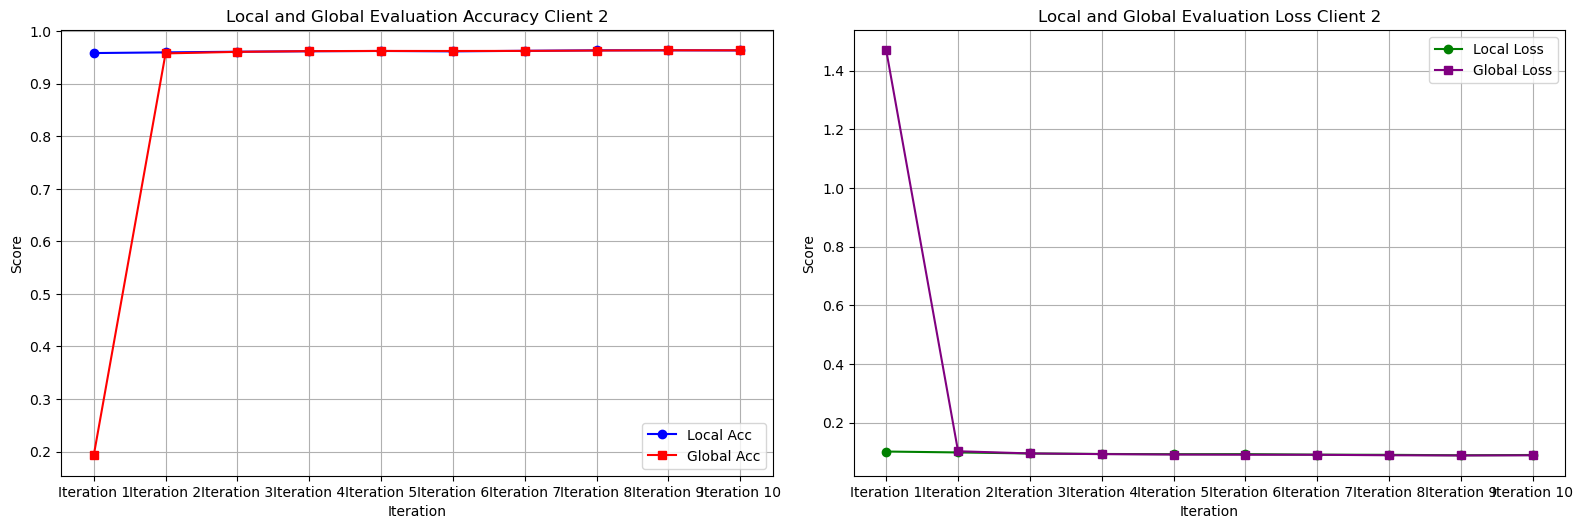

In [6]:
# Phần vẽ local/global evaluation
for i in range(len(active_clients_list)):
    file_path_local = tempdirs[i] + "local_val.csv"
    file_path_global = tempdirs[i] + "global_val.csv"
  
    local_val = pd.read_csv(file_path_local)
    global_val = pd.read_csv(file_path_global)
    plt.figure(figsize=(16, 10))
    plt.subplot(2, 2, 1)
    plt.plot(Iterations[f'client_{i}'], local_val['local_acc'], marker='o', linestyle='-', label="Local Acc", color='blue')
    plt.plot(Iterations[f'client_{i}'], global_val['global_acc'], marker='s', linestyle='-', label="Global Acc", color='red')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Accuracy Client {i}")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(Iterations[f'client_{i}'], local_val['local_loss'], marker='o', linestyle='-', label="Local Loss", color='green')
    plt.plot(Iterations[f'client_{i}'], global_val['global_loss'], marker='s', linestyle='-', label="Global Loss", color='purple')
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title(f"Local and Global Evaluation Loss Client {i}")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(tempdirs[i] + "/evaluation_acc_loss.png", dpi=300, bbox_inches="tight")
    plt.show()

Đã lưu biểu đồ vào file: multiclass_FL_log/Month07-Day07-14h-57p/resource_usage_plot_vertical.png


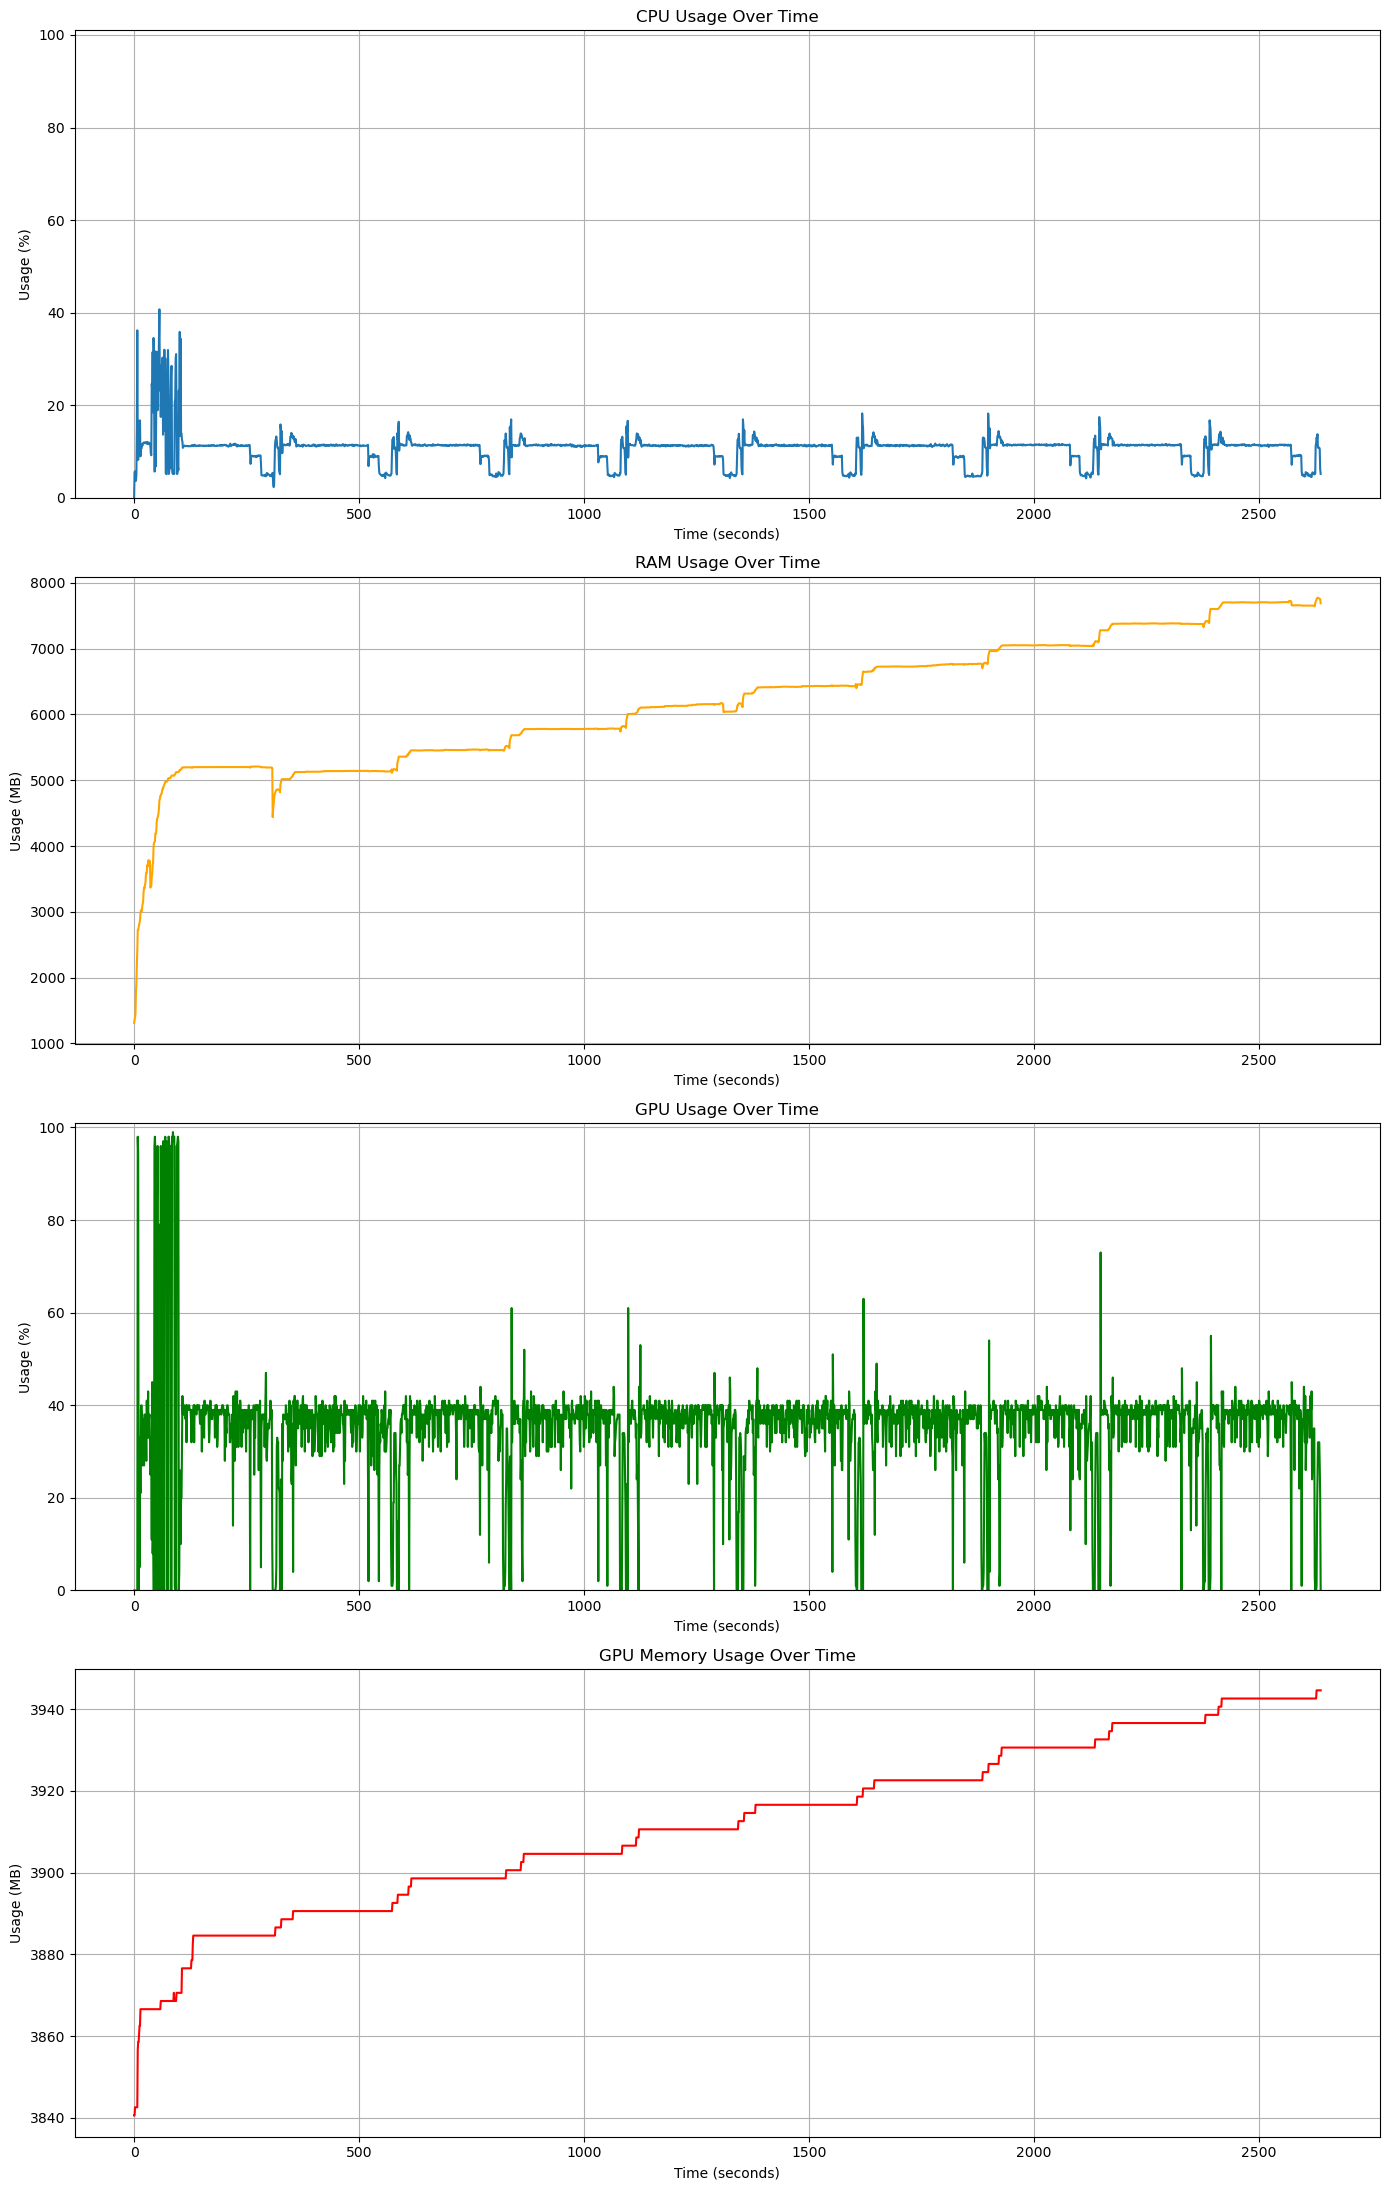

In [11]:
df = pd.read_csv(resource_usage)

# Tính toán thời gian đã trôi qua (tính bằng giây) từ lúc bắt đầu
df['elapsed_time'] = df['timestamp'] - df['timestamp'].iloc[0]  # Corrected iloc

# Tạo một figure lớn hơn
fig = plt.figure(figsize=(14, 22))  # Tăng chiều cao figure

# 1. Biểu đồ CPU Usage
ax1 = fig.add_subplot(4, 1, 1)  # 4 hàng, 1 cột, vị trí 1
ax1.plot(df['elapsed_time'], df['cpu_usage'], label='CPU Usage')
ax1.set_title('CPU Usage Over Time')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Usage (%)')
ax1.grid(True)
ax1.set_ylim(0, 101)

# 2. Biểu đồ RAM Usage
ax2 = fig.add_subplot(4, 1, 2)  # 4 hàng, 1 cột, vị trí 2
ax2.plot(df['elapsed_time'], df['ram_usage_mb'], color='orange', label='RAM Usage')
ax2.set_title('RAM Usage Over Time')
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Usage (MB)')
ax2.grid(True)

# 3. Biểu đồ GPU Usage
ax3 = fig.add_subplot(4, 1, 3)  # 4 hàng, 1 cột, vị trí 3
ax3.plot(df['elapsed_time'], df['gpu_usage'], color='green', label='GPU Usage')
ax3.set_title('GPU Usage Over Time')
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Usage (%)')
ax3.grid(True)
ax3.set_ylim(0, 101)

# 4. Biểu đồ GPU Memory Usage
ax4 = fig.add_subplot(4, 1, 4)  # 4 hàng, 1 cột, vị trí 4
ax4.plot(df['elapsed_time'], df['gpu_mem_usage_mb'], color='red', label='GPU Memory Usage')
ax4.set_title('GPU Memory Usage Over Time')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Usage (MB)')
ax4.grid(True)

# Điều chỉnh layout để tránh các tiêu đề và nhãn bị chồng lên nhau
plt.tight_layout()

# Lưu biểu đồ thành file ảnh
output_image_path = os.path.join(
    os.path.dirname(resource_usage),
    'resource_usage_plot_vertical.png'
)
plt.savefig(output_image_path)
print(f"Đã lưu biểu đồ vào file: {output_image_path}")

# Hiển thị biểu đồ
plt.show()